## Линейная регрессия: переобучение и регуляризация

In [50]:
import pandas as pd
import numpy as np
import sklearn
from matplotlib import pyplot as plt
%matplotlib inline

Мы будем работать с датасетом __"bikes_rent.csv"__, в котором по дням записаны календарная информация и погодные условия, характеризующие автоматизированные пункты проката велосипедов, а также число прокатов в этот день. Последнее мы будем предсказывать; таким образом, мы будем решать задачу регрессии.

### Знакомство с данными

In [51]:
df = pd.read_csv('bikes_rent.csv')
df.head(5)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,4.805490,985
1,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,7.443949,801
2,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,7.437060,1349
3,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,4.800998,1562
4,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,5.597810,1600


Для каждого дня проката известны следующие признаки:
* _season_: 1 - весна, 2 - лето, 3 - осень, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: от 1 до 12
* _holiday_: 0 - нет праздника, 1 - есть праздник
* _weekday_: от 0 до 6
* _workingday_: 0 - нерабочий день, 1 - рабочий день
* _weathersit_: оценка благоприятности погоды от 1 (чистый, ясный день) до 4 (ливень, туман)
* _temp_: температура в Цельсиях
* _atemp_: температура по ощущениям в Цельсиях
* _hum_: влажность
* _windspeed(mph)_: скорость ветра в милях в час
* _windspeed(ms)_: скорость ветра в метрах в секунду
* _cnt_: количество арендованных велосипедов (это целевой признак, его мы будем предсказывать)

Итак, у нас есть вещественные, бинарные и номинальные (порядковые) признаки, и со всеми из них можно работать как с вещественными.  
Посмотрим на графиках, как целевой признак зависит от остальных

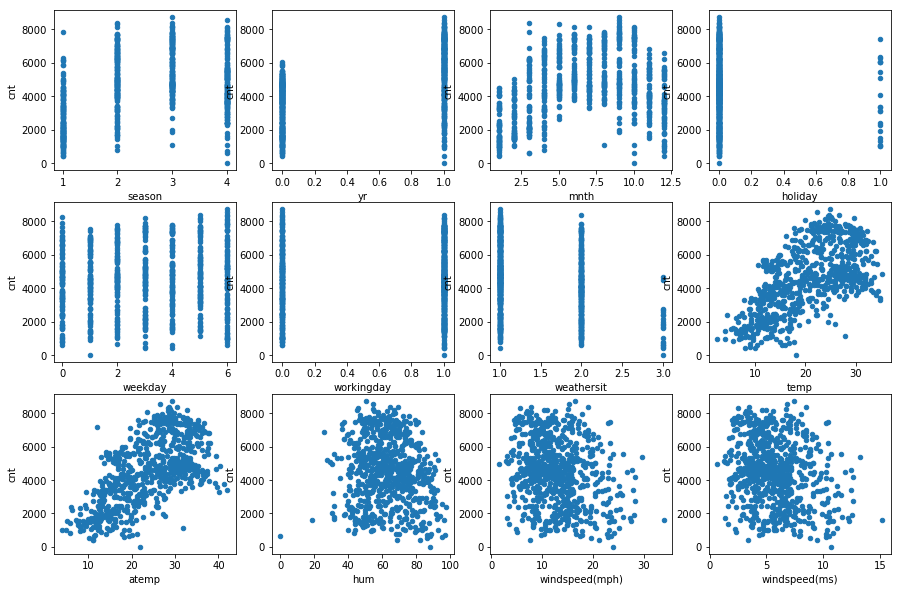

In [52]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
for idx, feature in enumerate(df.columns[:-1]):
    df.plot(feature, "cnt", subplots=True, kind="scatter", ax=axes[idx // 4, idx % 4])

Посчитаем корреляции признаков

In [53]:
df_corr=df.loc[:,df.columns[:-1]].corrwith(df.loc[:,'cnt'])
df_corr

season            0.406100
yr                0.566710
mnth              0.279977
holiday          -0.068348
weekday           0.067443
workingday        0.061156
weathersit       -0.297391
temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
dtype: float64

В выборке есть признаки, коррелирующие с целевым, а значит, задачу можно решать линейными методами.

По графикам видно, что некоторые признаки похожи друг на друга. Поэтому давайте также посчитаем корреляции между вещественными признаками.

In [113]:
pd.DataFrame(df, columns=['temp','atemp','hum','windspeed(mph)','windspeed(ms)','cnt']).corr()

,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
temp,1.000000,0.991702,0.126963,-0.157944,-0.157944,0.627494
atemp,0.991702,1.000000,0.139988,-0.183643,-0.183643,0.631066
hum,0.126963,0.139988,1.000000,-0.248489,-0.248489,-0.100659
windspeed(mph),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
windspeed(ms),-0.157944,-0.183643,-0.248489,1.000000,1.000000,-0.234545
cnt,0.627494,0.631066,-0.100659,-0.234545,-0.234545,1.000000


В матрице имеются еще две пары сильно коррелирующих столбцов: temp и atemp (коррелируют по своей природе) и два windspeed (потому что это просто перевод одних единиц в другие). Далее мы увидим, что этот факт негативно сказывается на обучении линейной модели.

Посмотрим средние признаков (метод mean), чтобы оценить масштаб признаков и доли 1 у бинарных признаков.

In [55]:
df.loc[:,df.columns[:-1]].mean()

season             2.496580
yr                 0.500684
mnth               6.519836
holiday            0.028728
weekday            2.997264
workingday         0.683995
weathersit         1.395349
temp              20.310776
atemp             23.717699
hum               62.789406
windspeed(mph)    12.762576
windspeed(ms)      5.705220
dtype: float64

Признаки имеют разный масштаб, значит для дальнейшей работы нам лучше нормировать матрицу объекты-признаки.

### Проблема первая: коллинеарные признаки

В наших данных один признак дублирует другой, и есть еще два очень похожих. Конечно, мы могли бы сразу удалить дубликаты, но давайте посмотрим, как бы происходило обучение модели, если бы мы не заметили эту проблему. 

Для начала проведем масштабирование, или стандартизацию признаков: из каждого признака вычтем его среднее и поделим на стандартное отклонение. Это можно сделать с помощью метода scale.

Кроме того, нужно перемешать выборку, это потребуется для кросс-валидации.

In [56]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [57]:
df_shuffled = shuffle(df, random_state=123)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте обучим линейную регрессию на наших данных и посмотрим на веса признаков.

In [59]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

In [85]:
linear_regressor = linear_model.LinearRegression()
linear_regressor.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [114]:
list(zip(df.columns[:-1], linear_regressor.coef_))

[('season', 570.87166018881931),
 ('yr', 1021.9681141542968),
 ('mnth', -141.30471071341395),
 ('holiday', -86.756216845717375),
 ('weekday', 137.22340368157441),
 ('workingday', 56.393735828395506),
 ('weathersit', -330.2317081049294),
 ('temp', 367.47305679011254),
 ('atemp', 585.55786521602681),
 ('hum', -145.60737566070202),
 ('windspeed(mph)', 12457919068698.219),
 ('windspeed(ms)', -12457919068896.668)]

Мы видим, что веса при линейно-зависимых признаках по модулю значительно больше, чем при других признаках.

Чтобы понять, почему так произошло, вспомним аналитическую формулу, по которой вычисляются веса линейной модели в методе наименьших квадратов:

$w = (X^TX)^{-1} X^T y$.

Если в X есть коллинеарные (линейно-зависимые) столбцы, матрица $X^TX$ становится вырожденной, и формула перестает быть корректной. Чем более зависимы признаки, тем меньше определитель этой матрицы и тем хуже аппроксимация $Xw \approx y$. Такая ситуацию называют _проблемой мультиколлинеарности_.

__Решение__ проблемы мультиколлинеарности состоит в _регуляризации_ линейной модели. К оптимизируемому функционалу прибавляют L1 или L2 норму весов, умноженную на коэффициент регуляризации $\alpha$.

Обучим регрессоры Ridge и Lasso с параметрами по умолчанию и убедимся, что проблема с весами решилась.

In [94]:
from sklearn.linear_model import Lasso, Ridge

In [115]:
lasso_regressor = linear_model.Lasso()
lasso_regressor.fit(X, y)
list(zip(df.columns[:-1], lasso_regressor.coef_))

[('season', 560.2416160308868),
 ('yr', 1019.4634940657199),
 ('mnth', -128.73062703678758),
 ('holiday', -86.152781333711047),
 ('weekday', 137.34789390496303),
 ('workingday', 55.21237064135682),
 ('weathersit', -332.36985696234876),
 ('temp', 376.3632362096975),
 ('atemp', 576.53079350455221),
 ('hum', -144.12915500348589),
 ('windspeed(mph)', -197.13968940248512),
 ('windspeed(ms)', -2.8050416772134453e-08)]

In [116]:
ridge_regressor = linear_model.Ridge()
ridge_regressor.fit(X, y)
list(zip(df.columns[:-1], ridge_regressor.coef_))

[('season', 563.06457225201268),
 ('yr', 1018.9483787875282),
 ('mnth', -131.8733202824726),
 ('holiday', -86.746097997092505),
 ('weekday', 138.00511117871898),
 ('workingday', 55.903110375064529),
 ('weathersit', -332.34978849907282),
 ('temp', 386.45788919194013),
 ('atemp', 566.34704706003595),
 ('hum', -145.07132729867257),
 ('windspeed(mph)', -99.259441081826438),
 ('windspeed(ms)', -99.259441154307126)]

### Проблема вторая: неинформативные признаки

В отличие от L2-регуляризации, L1 обнуляет веса при некоторых признаках. 

Давайте пронаблюдаем, как меняются веса при увеличении коэффициента регуляризации $\alpha$.

In [121]:
alphas = np.arange(1, 500, 50)
coefs_lasso = np.zeros((alphas.shape[0], X.shape[1])) # матрица весов размера (число регрессоров) x (число признаков)
coefs_ridge = np.zeros((alphas.shape[0], X.shape[1]))
# Для каждого значения коэффициента из alphas обучаем регрессор Lasso
# и записываем веса в соответствующую строку матрицы coefs_lasso,
# а затем обучаем Ridge и записываем веса в coefs_ridge.
for id_x, alpha in enumerate(alphas):
    my_lasso = linear_model.Lasso(alpha=alpha).fit(X,y)
    coefs_lasso[id_x,:] = my_lasso.coef_
    my_ridge = linear_model.Ridge(alpha=alpha).fit(X,y)
    coefs_ridge[id_x,:] = my_ridge.coef_

Визуализируем динамику весов при увеличении параметра регуляризации:

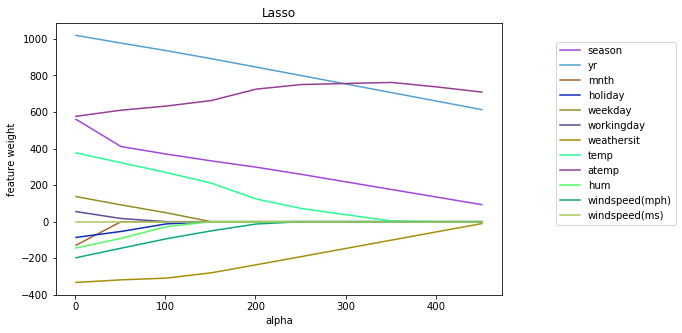

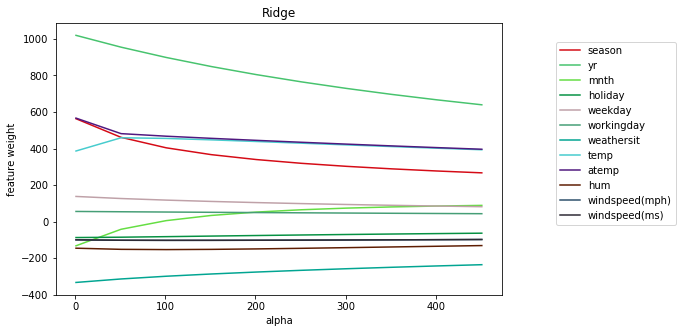

In [122]:
plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))
plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

Итак, мы видим, что при изменении alpha модель по-разному подбирает коэффициенты признаков. Нам нужно выбрать наилучшее alpha. 

Для этого, во-первых, нам нужна метрика качества. Будем использовать в качестве метрики сам оптимизируемый функционал метода наименьших квадратов, то есть Mean Square Error.

Во-вторых, нужно понять, на каких данных эту метрику считать. Нельзя выбирать alpha по значению MSE на обучающей выборке, потому что тогда мы не сможем оценить, как модель будет делать предсказания на новых для нее данных. Если мы выберем одно разбиение выборки на обучающую и тестовую (holdout), то настроимся на конкретные "новые" данные, и вновь можем переобучиться. Поэтому будем делать несколько разбиений выборки, на каждом пробовать разные значения alpha, а затем усреднять MSE. Удобнее всего делать такие разбиения кросс-валидацией, то есть разделить выборку на K частей и каждый раз брать одну из них как тестовую, а из оставшихся блоков составлять обучающую выборку. 

In [123]:
from sklearn.linear_model import LassoCV

Alpha: 6
Coefs:  [('season', 532.01898284135359), ('yr', 1015.0602226430593), ('mnth', -100.03952614356638), ('holiday', -83.293959875299095), ('weekday', 132.50446549095807), ('workingday', 51.557085614073848), ('weathersit', -330.55985673998123), ('temp', 370.67985503003598), ('atemp', 581.39693106549589), ('hum', -140.00740550068895), ('windspeed(mph)', -191.77140847135107), ('windspeed(ms)', -2.6854208375775755e-08)]


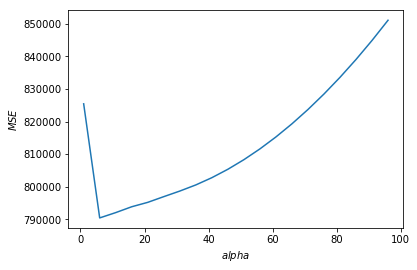

In [125]:
alphas = np.arange(1, 100, 5)
lassoCV_regressor = linear_model.LassoCV(alphas = alphas)
lassoCV_regressor.fit(X, y)
MSE = np.zeros(alphas.shape)
for id_x,line in enumerate(lassoCV_regressor.mse_path_):
    MSE[id_x] = np.mean(line)
plt.xlabel('$alpha$')
plt.ylabel('$MSE$')
plt.plot(lassoCV_regressor.alphas_,MSE)
print('Alpha:', lassoCV_regressor.alphas_[np.argmin(MSE)])
print('Coefs: ',list(zip(df.columns[:-1], lassoCV_regressor.coef_)))

Итак, мы выбрали некоторый параметр регуляризации. Давайте посмотрим, какие бы мы выбирали alpha, если бы делили выборку только один раз на обучающую и тестовую, то есть рассмотрим траектории MSE, соответствующие отдельным блокам выборки.

41
6
1


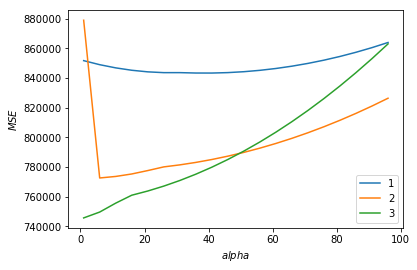

In [137]:
MSE = []
for i in range(3):
    MSE.append(np.zeros(alphas.shape))

for id_x,line in enumerate(lassoCV_regressor.mse_path_):
    for i in range(3):
        MSE[i][id_x] = line[i]
plt.xlabel('$alpha$')
plt.ylabel('$MSE$')
plt.plot(lassoCV_regressor.alphas_,MSE[0],label='1')
plt.plot(lassoCV_regressor.alphas_,MSE[1],label='2')
plt.plot(lassoCV_regressor.alphas_,MSE[2],label='3')
plt.legend(loc='best')
print(lassoCV_regressor.alphas_[np.argmin(MSE[0])])
print(lassoCV_regressor.alphas_[np.argmin(MSE[1])])
print(lassoCV_regressor.alphas_[np.argmin(MSE[2])])

На каждом разбиении оптимальное значение alpha свое, и ему соответствует большое MSE на других разбиениях. Получается, что мы настраиваемся на конкретные обучающие и контрольные выборки. При выборе alpha на кросс-валидации мы выбираем нечто "среднее", что будет давать приемлемое значение метрики на разных разбиениях выборки. 

### Заключение
Итак, мы посмотрели, как можно следить за адекватностью линейной модели, как отбирать признаки и как грамотно, по возможности не настраиваясь на какую-то конкретную порцию данных, подбирать коэффициент регуляризации. 